<a href="https://colab.research.google.com/github/suruchi2010/SSN-projects/blob/main/Dysarthic_uaspeech_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install -U praat-parselmouth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.7 MB 3.6 MB/s 


In [ ]:
import glob
import numpy as np
import pandas as pd
import parselmouth 
import statistics
import matplotlib.pyplot as plt
import seaborn as sns


from parselmouth.praat import call
from scipy.stats.mstats import zscore
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
from glob import glob 
#glob()

from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

path = "/content/gdrive/My Drive/UA_PHASE"
audio_files= glob(path + '/*/*/*.wav', recursive=True)
#audio_files
len(audio_files)

#str1=[]
#for ele in audio_files:
 # str1.append(str(ele))
#print(str1)

#list

Mounted at /content/gdrive


230

In [ ]:
#len(audio_files[2])
audio_files[0]

'/content/gdrive/My Drive/UA_PHASE/F02_MILD/digits/EIGHT_12.wav'

In [ ]:
snd = parselmouth.Sound(audio_files[1])
#sound = parselmouth.Sound("audio/4_b.wav")

from IPython.display import Audio
Audio(data=snd.values, rate=snd.sampling_frequency)

In [ ]:
sns.set() # Use seaborn's default style to make attractive graphs
plt.rcParams['figure.dpi'] = 100 # Show nicely large images in this notebook

\Here we have taken a dysarthic speaker data saying "EIGHT"

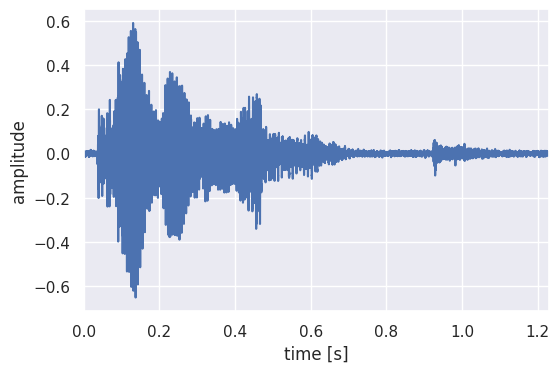

In [ ]:
plt.figure()
plt.plot(snd.xs(), snd.values.T)
plt.xlim([snd.xmin, snd.xmax])
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.show()

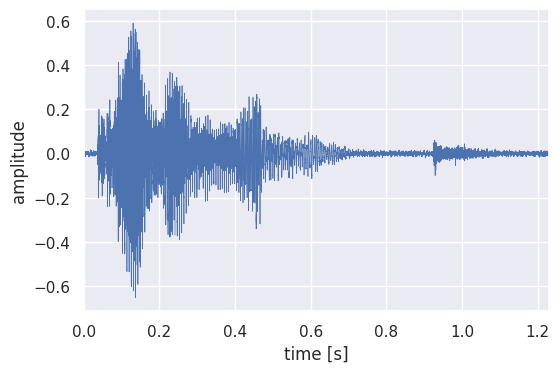

In [ ]:
snd_part = snd.extract_part(from_time=2.5, preserve_times=True)

plt.figure()
plt.plot(snd_part.xs(), snd_part.values.T, linewidth=0.5)
plt.xlim([snd_part.xmin, snd_part.xmax])
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.show()

Next, we can write a couple of ordinary Python functions to plot a Parselmouth Spectrogram and Intensity

In [ ]:
def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=2, color='w')
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")

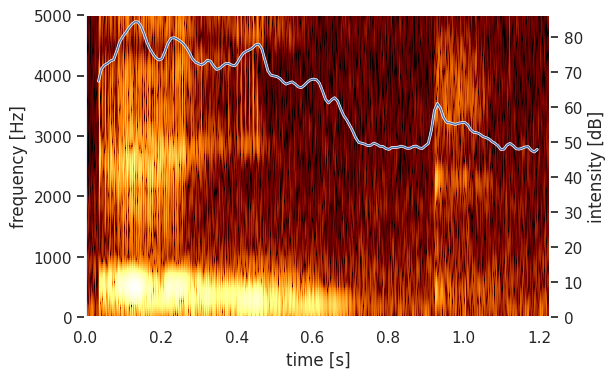

In [ ]:
intensity = snd.to_intensity()
spectrogram = snd.to_spectrogram()
plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_intensity(intensity)
plt.xlim([snd.xmin, snd.xmax])
plt.show()

Praat calculate the pitch of the fragment, so we can plot it instead of the intensity.

In [ ]:
def draw_pitch(pitch):
    # Extract selected pitch contour, and
    # replace unvoiced samples by NaN to not plot
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2)
    plt.grid(False)
    plt.ylim(0, pitch.ceiling)
    plt.ylabel("fundamental frequency [Hz]")

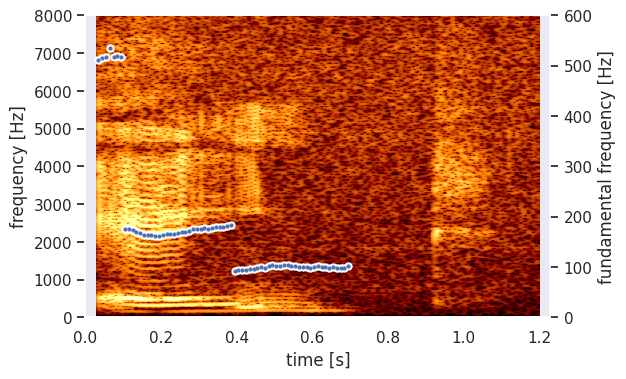

In [ ]:
pitch = snd.to_pitch()

# If desired, pre-emphasize the sound fragment before calculating the spectrogram
pre_emphasized_snd = snd.copy()
pre_emphasized_snd.pre_emphasize()
spectrogram = pre_emphasized_snd.to_spectrogram(window_length=0.030, maximum_frequency=8000)


plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_pitch(pitch)
plt.xlim([snd.xmin, snd.xmax])
plt.show()

In [ ]:
# This is the function to measure source acoustics using default male parameters.


def measurePitch(voiceID, f0min, f0max, unit):
    sound = parselmouth.Sound(voiceID) # read the sound
    duration = call(sound, "Get total duration") # duration
    pitch = call(sound, "To Pitch", 0.0, f0min, f0max) #create a praat pitch object
    meanF0 = call(pitch, "Get mean", 0, 0, unit) # get mean pitch
    stdevF0 = call(pitch, "Get standard deviation", 0 ,0, unit) # get standard deviation
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, f0min, 0.1, 1.0)
    hnr = call(harmonicity, "Get mean", 0, 0)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    localJitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    localabsoluteJitter = call(pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3)
    rapJitter = call(pointProcess, "Get jitter (rap)", 0, 0, 0.0001, 0.02, 1.3)
    ppq5Jitter = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)
    ddpJitter = call(pointProcess, "Get jitter (ddp)", 0, 0, 0.0001, 0.02, 1.3)
    localShimmer =  call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    localdbShimmer = call([sound, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq3Shimmer = call([sound, pointProcess], "Get shimmer (apq3)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    aqpq5Shimmer = call([sound, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq11Shimmer =  call([sound, pointProcess], "Get shimmer (apq11)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    ddaShimmer = call([sound, pointProcess], "Get shimmer (dda)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    
    return duration, meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer


In [ ]:
# This function measures formants using Formant Position formula
def measureFormants(sound, wave_file, f0min,f0max):
    sound = parselmouth.Sound(sound) # read the sound
    pitch = call(sound, "To Pitch (cc)", 0, f0min, 15, 'no', 0.03, 0.45, 0.01, 0.35, 0.14, f0max)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    
    formants = call(sound, "To Formant (burg)", 0.0025, 5, 5000, 0.025, 50)
    numPoints = call(pointProcess, "Get number of points")

    f1_list = []
    f2_list = []
    f3_list = []
    f4_list = []
    
    # Measure formants only at glottal pulses
    for point in range(0, numPoints):
        point += 1
        t = call(pointProcess, "Get time from index", point)
        f1 = call(formants, "Get value at time", 1, t, 'Hertz', 'Linear')
        f2 = call(formants, "Get value at time", 2, t, 'Hertz', 'Linear')
        f3 = call(formants, "Get value at time", 3, t, 'Hertz', 'Linear')
        f4 = call(formants, "Get value at time", 4, t, 'Hertz', 'Linear')
        f1_list.append(f1)
        f2_list.append(f2)
        f3_list.append(f3)
        f4_list.append(f4)
    
    f1_list = [f1 for f1 in f1_list if str(f1) != 'nan']
    f2_list = [f2 for f2 in f2_list if str(f2) != 'nan']
    f3_list = [f3 for f3 in f3_list if str(f3) != 'nan']
    f4_list = [f4 for f4 in f4_list if str(f4) != 'nan']
    
    # calculate mean formants across pulses
    f1_mean = statistics.mean(f1_list)
    f2_mean = statistics.mean(f2_list)
    f3_mean = statistics.mean(f3_list)
    f4_mean = statistics.mean(f4_list)
    
    # calculate median formants across pulses, this is what is used in all subsequent calcualtions
    # you can use mean if you want, just edit the code in the boxes below to replace median with mean
    f1_median = statistics.median(f1_list)
    f2_median = statistics.median(f2_list)
    f3_median = statistics.median(f3_list)
    f4_median = statistics.median(f4_list)
    
    return f1_mean, f2_mean, f3_mean, f4_mean, f1_median, f2_median, f3_median, f4_median


#def runPCA(df):
    # z-score the Jitter and Shimmer measurements
    #measures = ['localJitter', 'localabsoluteJitter', 'rapJitter', 'ppq5Jitter', 'ddpJitter',
                #'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 'apq11Shimmer', 'ddaShimmer']
    #x = df.loc[:, measures].values
    #x = StandardScaler().fit_transform(x)
    # PCA
    #pca = PCA(n_components=2)
    #principalComponents = pca.fit_transform(x)
    #principalDf = pd.DataFrame(data = principalComponents, columns = ['JitterPCA', 'ShimmerPCA'])
   #principalDf
    #return principalDf

In [ ]:
# create lists to put the results
file_list = []
duration_list = []
mean_F0_list = []
sd_F0_list = []
hnr_list = []
localJitter_list = []
localabsoluteJitter_list = []
rapJitter_list = []
ppq5Jitter_list = []
ddpJitter_list = []
localShimmer_list = []
localdbShimmer_list = []
apq3Shimmer_list = []
aqpq5Shimmer_list = []
apq11Shimmer_list = []
ddaShimmer_list = []
f1_mean_list = []
f2_mean_list = []
f3_mean_list = []
f4_mean_list = []
f1_median_list = []
f2_median_list = []
f3_median_list = []
f4_median_list = []



    
    # add the formant data
    f1_mean_list.append(f1_mean)
    f2_mean_list.append(f2_mean)
    f3_mean_list.append(f3_mean)
    f4_mean_list.append(f4_mean)
    f1_median_list.append(f1_median)
    f2_median_list.append(f2_median)
    f3_median_list.append(f3_median)
    f4_median_list.append(f4_median)# Go through all the wave files in the folder and measure all the acoustics
for wave_file in audio_files:
    sound = parselmouth.Sound(wave_file)
    (duration, meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, 
     localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer) = measurePitch(
        sound, 75, 300, "Hertz")
    (f1_mean, f2_mean, f3_mean, f4_mean, f1_median, f2_median, f3_median, f4_median) = measureFormants(
        sound, wave_file, 75, 300)
    file_list.append(wave_file) # make an ID list
    duration_list.append(duration) # make duration list
    mean_F0_list.append(meanF0) # make a mean F0 list
    sd_F0_list.append(stdevF0) # make a sd F0 list
    hnr_list.append(hnr) #add HNR data
    
    # add raw jitter and shimmer measures
    localJitter_list.append(localJitter)
    localabsoluteJitter_list.append(localabsoluteJitter)
    rapJitter_list.append(rapJitter)
    ppq5Jitter_list.append(ppq5Jitter)
    ddpJitter_list.append(ddpJitter)
    localShimmer_list.append(localShimmer)
    localdbShimmer_list.append(localdbShimmer)
    apq3Shimmer_list.append(apq3Shimmer)
    aqpq5Shimmer_list.append(aqpq5Shimmer)
    apq11Shimmer_list.append(apq11Shimmer)
    ddaShimmer_list.append(ddaShimmer)

In [ ]:
# Add the data to Pandas
df = pd.DataFrame(np.column_stack([file_list, duration_list, mean_F0_list, sd_F0_list, hnr_list, 
                                   localJitter_list, localabsoluteJitter_list, rapJitter_list, 
                                   ppq5Jitter_list, ddpJitter_list, localShimmer_list, 
                                   localdbShimmer_list, apq3Shimmer_list, aqpq5Shimmer_list, 
                                   apq11Shimmer_list, ddaShimmer_list, f1_mean_list, 
                                   f2_mean_list, f3_mean_list, f4_mean_list, 
                                   f1_median_list, f2_median_list, f3_median_list, 
                                   f4_median_list]),
                                   columns=['voiceID', 'duration', 'meanF0Hz', 'stdevF0Hz', 'HNR', 
                                            'localJitter', 'localabsoluteJitter', 'rapJitter', 
                                            'ppq5Jitter', 'ddpJitter', 'localShimmer', 
                                            'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 
                                            'apq11Shimmer', 'ddaShimmer', 'f1_mean', 'f2_mean', 
                                            'f3_mean', 'f4_mean', 'f1_median', 
                                            'f2_median', 'f3_median', 'f4_median'])

#pcaData = runPCA(df) # Run jitter and shimmer PCA
#df = pd.concat([df, pcaData], axis=1) # Add PCA data


# reload the data so it's all numbers
df.to_csv("processed_results.csv", index=False)
df = pd.read_csv('processed_results.csv', header=0)
#df
df.sort_values('voiceID').head(10)

,voiceID,duration,meanF0Hz,stdevF0Hz,HNR,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,ddpJitter,...,apq11Shimmer,ddaShimmer,f1_mean,f2_mean,f3_mean,f4_mean,f1_median,f2_median,f3_median,f4_median
27,/content/gdrive/My Drive/UA_PHASE/F02_MILD/com...,1.5850,189.339654,48.674043,5.329559,0.062150,0.000320,0.035432,0.038069,0.106295,...,0.178227,0.348642,654.135931,1230.168201,2563.931391,3500.117657,692.472378,1014.525912,2461.858399,3391.242685
25,/content/gdrive/My Drive/UA_PHASE/F02_MILD/com...,1.5850,151.691269,52.026031,5.625826,0.064466,0.000418,0.033688,0.039603,0.101063,...,0.119262,0.266540,687.007785,1083.638314,2420.554687,3362.485734,704.217189,898.380479,2360.276576,3290.649176
29,/content/gdrive/My Drive/UA_PHASE/F02_MILD/com...,1.5850,167.908261,38.494892,5.265196,0.073133,0.000435,0.041304,0.045349,0.123913,...,0.128146,0.302797,717.514257,1046.803628,2527.537899,3565.249424,704.223460,884.437377,2473.395288,3488.005654
26,/content/gdrive/My Drive/UA_PHASE/F02_MILD/com...,1.5850,174.948965,33.445151,5.068620,0.062105,0.000361,0.035843,0.041575,0.107528,...,NaN,0.338313,692.861575,879.898140,2290.841719,3375.479887,691.245585,827.977688,2269.752982,3344.558474
20,/content/gdrive/My Drive/UA_PHASE/F02_MILD/com...,1.5850,189.490750,38.889347,5.012596,0.038594,0.000206,0.019248,0.022379,0.057743,...,0.179127,0.232412,651.239404,1030.859201,2293.458442,3401.176121,658.156388,878.604541,2247.387262,3365.187607
23,/content/gdrive/My Drive/UA_PHASE/F02_MILD/com...,1.5850,172.132040,30.728826,4.850464,0.048351,0.000278,0.027224,0.035784,0.081672,...,0.199022,0.342906,645.724008,1081.365252,2322.261681,3375.957807,691.400072,890.326929,2267.837931,3342.409031
24,/content/gdrive/My Drive/UA_PHASE/F02_MILD/com...,1.5850,144.388764,34.155384,4.428240,0.065155,0.000444,0.036456,0.043468,0.109368,...,0.175082,0.438255,716.900635,1672.086811,2824.638864,3803.876710,699.468453,1730.074931,2765.848151,3718.844274
22,/content/gdrive/My Drive/UA_PHASE/F02_MILD/com...,1.2775,159.160519,38.994490,8.861260,0.034707,0.000219,0.012856,0.016850,0.038568,...,0.141792,0.137696,641.653277,1066.716612,2422.379865,3521.083190,609.496146,927.337204,2246.602548,3343.104938
28,/content/gdrive/My Drive/UA_PHASE/F02_MILD/com...,1.2775,157.651955,42.625696,8.868629,0.035510,0.000222,0.010258,0.010394,0.030775,...,0.158648,0.164291,637.100812,965.526981,2365.447927,3481.165635,624.130566,900.000281,2290.153355,3367.760922
21,/content/gdrive/My Drive/UA_PHASE/F02_MILD/com...,1.2775,158.637140,41.292989,9.217030,0.020456,0.000125,0.007586,0.006124,0.022759,...,0.138188,0.122899,643.101265,949.321625,2508.464504,3485.628670,615.042718,840.004456,2454.921135,3385.777573


In [ ]:
df.shape

(230, 24)

In [ ]:
df.columns

Index(['voiceID', 'duration', 'meanF0Hz', 'stdevF0Hz', 'HNR', 'localJitter',
       'localabsoluteJitter', 'rapJitter', 'ppq5Jitter', 'ddpJitter',
       'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer',
       'apq11Shimmer', 'ddaShimmer', 'f1_mean', 'f2_mean', 'f3_mean',
       'f4_mean', 'f1_median', 'f2_median', 'f3_median', 'f4_median'],
      dtype='object')

In [ ]:
#df.to_excel("Dysarthic_features.xlsx") 

XGBoost classification using accoustic features extracted for Dysarthic Speaker using parselmouth(like Praat)

In [ ]:
import numpy as np
import pandas as pd
import os, sys
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
df=pd.read_excel('Dysarthic_features.xlsx')
df.head()

,Unnamed: 0,voiceID,duration,meanF0Hz,stdevF0Hz,HNR,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,...,ddaShimmer,f1_mean,f2_mean,f3_mean,f4_mean,f1_median,f2_median,f3_median,f4_median,Speaker_Severity
0,0,/content/gdrive/My Drive/UA_PHASE/F02_MILD/dig...,0.810000,182.213259,69.285226,7.183164,0.053623,0.000289,0.031190,0.031455,...,0.203098,451.869879,2084.220103,2715.705676,3550.781366,468.362515,2037.147363,2654.123015,3506.674889,MILD
1,1,/content/gdrive/My Drive/UA_PHASE/F02_MILD/dig...,1.229313,135.340526,36.841151,10.839321,0.017012,0.000125,0.008810,0.008978,...,0.132990,450.307424,1939.956286,2780.821031,3767.419440,405.759733,2007.337688,2760.820087,3756.162093,MILD
2,2,/content/gdrive/My Drive/UA_PHASE/F02_MILD/dig...,0.810000,158.885438,59.819425,6.164232,0.073609,0.000458,0.041764,0.033016,...,0.316265,464.046748,2009.674715,2677.789610,3637.974150,474.531384,2030.455396,2618.747698,3566.861182,MILD
3,3,/content/gdrive/My Drive/UA_PHASE/F02_MILD/dig...,1.229313,134.845585,36.789543,11.543327,0.017566,0.000130,0.009034,0.008946,...,0.128018,407.699613,1979.928866,2779.159252,3839.845694,391.513452,2076.852488,2750.539933,3830.661160,MILD
4,4,/content/gdrive/My Drive/UA_PHASE/F02_MILD/dig...,1.229313,134.925439,36.811467,12.095235,0.015640,0.000116,0.007887,0.008415,...,0.145422,418.449356,1893.133863,2780.708869,3737.142126,388.080743,1977.157990,2759.791168,3688.841372,MILD


In [ ]:
df1=df.drop(['voiceID'], axis=1)

In [ ]:
X=df1.loc[:,df1.columns!= 'Speaker_Severity'].values[:,1:]
Y=df1.loc[:,'Speaker_Severity'].values
#labels=df.loc[:,'status'].values

In [ ]:
len(X)
X

array([[8.10000000e-01, 1.82213259e+02, 6.92852264e+01, ...,
        2.03714736e+03, 2.65412301e+03, 3.50667489e+03],
       [1.22931250e+00, 1.35340526e+02, 3.68411514e+01, ...,
        2.00733769e+03, 2.76082009e+03, 3.75616209e+03],
       [8.10000000e-01, 1.58885438e+02, 5.98194253e+01, ...,
        2.03045540e+03, 2.61874770e+03, 3.56686118e+03],
       ...,
       [1.02556250e+00, 1.25401201e+02, 9.22501750e+00, ...,
        1.20762707e+03, 2.48391092e+03, 3.65039384e+03],
       [1.02556250e+00, 1.22529770e+02, 1.44794580e+01, ...,
        1.18373133e+03, 2.51329406e+03, 3.59662335e+03],
       [1.02556250e+00, 1.27308509e+02, 8.23022898e+00, ...,
        1.19836288e+03, 2.49893103e+03, 3.55266249e+03]])

In [ ]:
len(Y)
Y

array(['MILD', 'MILD', 'MILD', 'MILD', 'MILD', 'MILD', 'MILD', 'MILD',
       'MILD', 'MILD', 'MILD', 'MILD', 'MILD', 'MILD', 'MILD', 'MILD',
       'MILD', 'MILD', 'MILD', 'MILD', 'MILD', 'MILD', 'MILD', 'MILD',
       'MILD', 'MILD', 'MILD', 'MILD', 'MILD', 'MILD', 'HIGH', 'HIGH',
       'HIGH', 'HIGH', 'HIGH', 'HIGH', 'HIGH', 'HIGH', 'HIGH', 'HIGH',
       'HIGH', 'HIGH', 'HIGH', 'HIGH', 'HIGH', 'HIGH', 'HIGH', 'HIGH',
       'HIGH', 'HIGH', 'HIGH', 'HIGH', 'HIGH', 'HIGH', 'HIGH', 'HIGH',
       'HIGH', 'HIGH', 'HIGH', 'HIGH', 'HIGH', 'HIGH', 'HIGH', 'HIGH',
       'HIGH', 'HIGH', 'HIGH', 'HIGH', 'HIGH', 'HIGH', 'HIGH', 'HIGH',
       'HIGH', 'HIGH', 'HIGH', 'HIGH', 'HIGH', 'HIGH', 'HIGH', 'HIGH',
       'HIGH', 'HIGH', 'HIGH', 'HIGH', 'HIGH', 'HIGH', 'HIGH', 'HIGH',
       'HIGH', 'HIGH', 'LOW', 'LOW', 'LOW', 'LOW', 'LOW', 'LOW', 'LOW',
       'LOW', 'LOW', 'LOW', 'LOW', 'LOW', 'LOW', 'LOW', 'LOW', 'LOW',
       'LOW', 'LOW', 'LOW', 'LOW', 'LOW', 'LOW', 'LOW', 'LOW', 'LOW',
       

In [ ]:
#one_hot_encoded_data = pd.get_dummies(data, columns = ['Remarks', 'Gender'])
#print(one_hot_encoded_data)

In [ ]:
scaler=MinMaxScaler((-1,1))
x=scaler.fit_transform(X)
y=Y

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.2, random_state=7)

In [ ]:
# Train the model

import xgboost as xgb

#xgb_classifier = xgb.XGBClassifier()
#xgb_classifier.fit(x_train,y_train)

model=XGBClassifier()
model.fit(x_train,y_train)

XGBClassifier(objective='multi:softprob')

In [ ]:
predictions = model.predict(x_test)

In [ ]:
predictions

array(['MODERATE', 'MODERATE', 'HIGH', 'MILD', 'HIGH', 'MILD', 'MILD',
       'LOW', 'MILD', 'LOW', 'MILD', 'HIGH', 'MILD', 'LOW', 'MODERATE',
       'MILD', 'MODERATE', 'LOW', 'HIGH', 'LOW', 'MODERATE', 'MODERATE',
       'LOW', 'MODERATE', 'LOW', 'MODERATE', 'MODERATE', 'LOW', 'HIGH',
       'MODERATE', 'LOW', 'HIGH', 'MODERATE', 'HIGH', 'HIGH', 'MODERATE',
       'HIGH', 'HIGH', 'HIGH', 'MODERATE', 'HIGH', 'LOW', 'LOW', 'MILD',
       'MILD', 'MODERATE'], dtype=object)

In [ ]:
print("Accuracy of Model::",accuracy_score(y_test,predictions))

Accuracy of Model:: 0.9782608695652174
